<a href="https://colab.research.google.com/github/hanselkane/MachineLearning-Telyu/blob/main/Week%207/ML_Telyu_Week_7_NYC_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
!pip install kaggle

In [3]:
# Make a directory to store kaggle token
!mkdir ~/.kaggle # the '~' symbol is equal '/root'

import json
token ={"username":"ultranumb","key":"2339326dcd65b7b358246915b2c32954"}
json_object = json.dumps(token, indent = 4)
  
# Writing to kaggle.json
with open("/root/.kaggle/kaggle.json", "w") as outfile:
    outfile.write(json_object)

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!chmod 600 ~/.kaggle/kaggle.json # Changing permission access to kaggle.json

In [5]:
# Download the dataset
# !kaggle competitions download <name-of-the-competition>
!kaggle competitions download nyc-taxi-trip-duration

nyc-taxi-trip-duration.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
#unzip the file
# !unzip nyc-taxi-trip-duration

In [7]:
# You could find all of these files in file explorer
# on the left side of your google colab screen (the folder symbol)
# !unzip test
# !unzip train
# !unzip sample_submission

In [8]:
# Load the data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [10]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [12]:
# Cut the outliers using 2 times standard deviation
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [13]:
# Cut the data to data that ONLY lies within NYC border
# New York city_long_border = (-74.03, -73.75)
# New York city_lat_border = (40.63, 40.85) 
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [14]:
# Reformat the data
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

In [15]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26


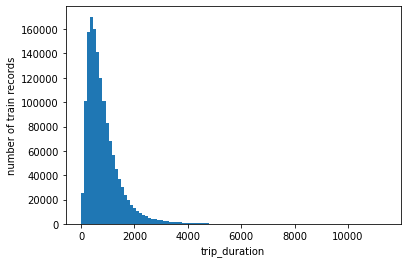

In [16]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

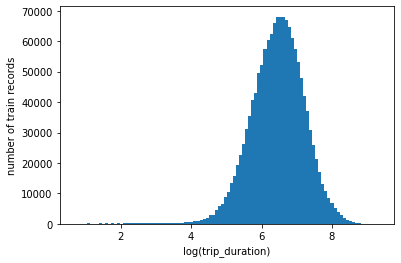

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


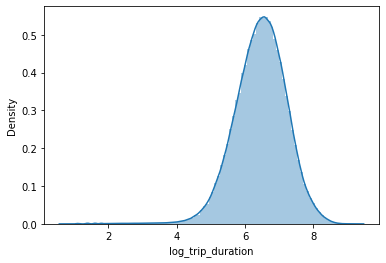

In [17]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

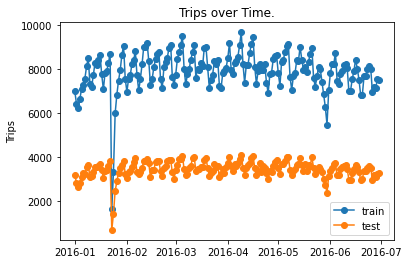

In [18]:
# Check if the test data is sampled from the training data
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

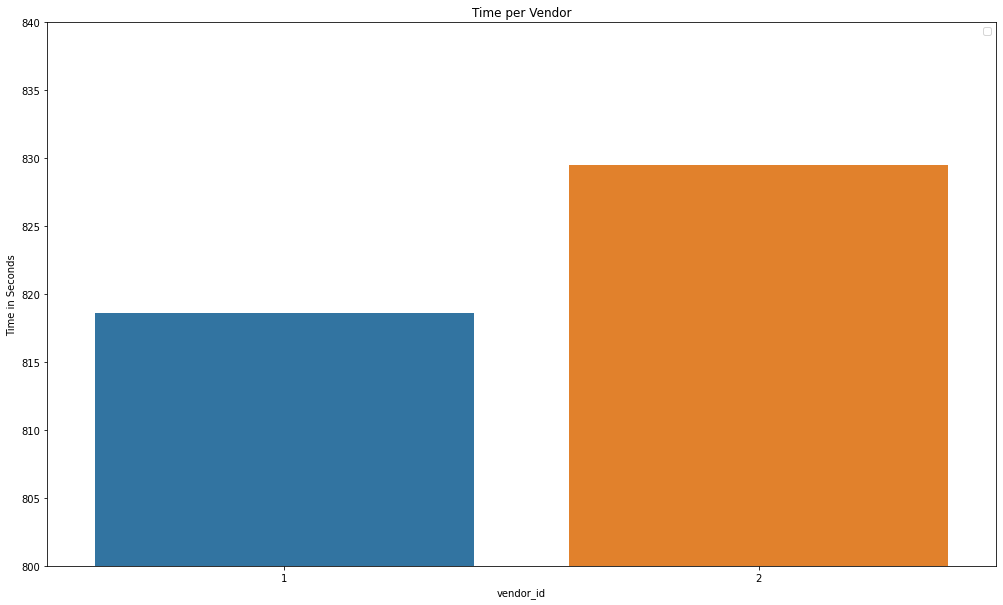

In [19]:
# Let's see whether different vendors make any difference

# ignore system warnings
import warnings
warnings.filterwarnings("ignore")

plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

No handles with labels found to put in legend.


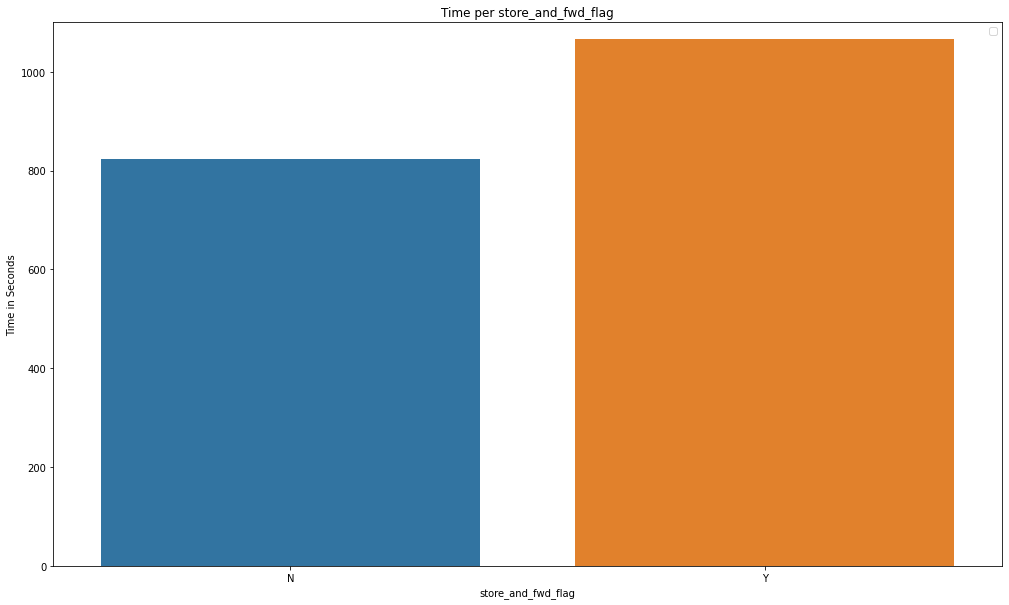

In [20]:
# Let's see whether the store and forward flag
# contribute to the difference of travel time.
# Store and forward, in this case, is the
# action of dropping many passanger in a 
# single car to multiple different areas
# leading to many stops

snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

No handles with labels found to put in legend.


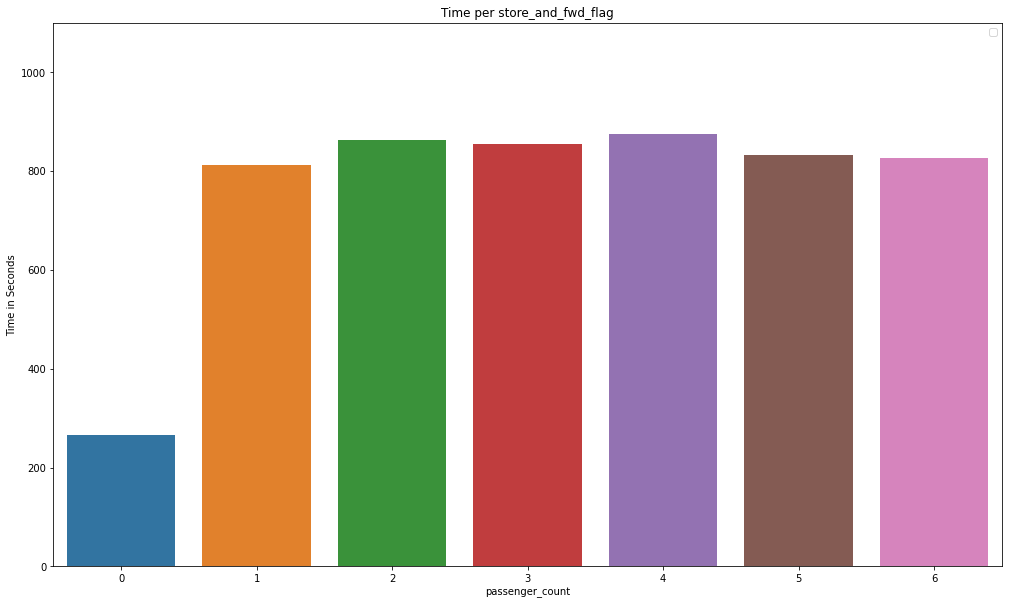

In [21]:
# Let's get another insight by grouping the data
# by passenger count
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [22]:
zeroPassenger = train.query('passenger_count == 0')
print(zeroPassenger.size," has zero passenger")
zeroPassenger.head()

676  has zero passenger


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,log_trip_duration
136519,id3645383,2,2016-01-01 05:01:32,2016-01-01 05:01:36,0,-73.993,40.757,-73.993,40.758,N,4,2016-01-01,1.609
194288,id2840829,2,2016-02-21 01:33:52,2016-02-21 01:36:27,0,-73.946,40.773,-73.947,40.775,N,155,2016-02-21,5.050
217765,id3762593,1,2016-01-04 12:24:17,2016-01-04 13:01:48,0,-73.815,40.700,-73.951,40.755,N,2251,2016-01-04,7.720
263809,id2154895,1,2016-05-23 23:37:37,2016-05-23 23:37:45,0,-73.862,40.705,-73.862,40.705,N,8,2016-05-23,2.197
278290,id0796773,1,2016-02-07 17:23:48,2016-02-07 17:23:57,0,-73.955,40.688,-73.955,40.688,N,9,2016-02-07,2.303


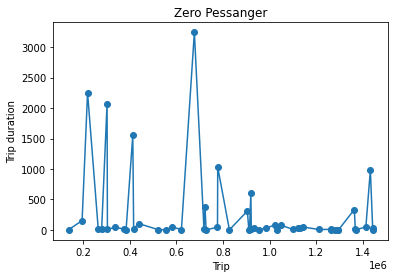

In [23]:
plt.plot(zeroPassenger['trip_duration'], 'o-', label='test')
plt.title('Zero Pessanger')
plt.ylabel('Trip duration')
plt.xlabel('Trip')
plt.show()

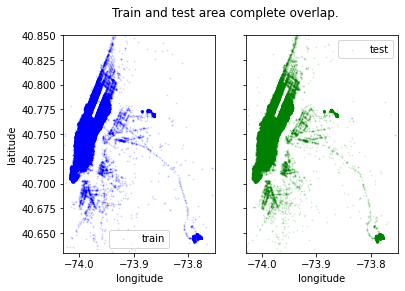

In [24]:
# Plot the train and test data to make sure
# that they come from the same set of data
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [25]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [26]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values) 

In [27]:
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [28]:
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [29]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [30]:
sample_ind = np.random.permutation(len(coords))[:500000]
# Pick random data from coords matrix to then perform kmeans clustering
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [31]:
# Use the fitted model to predict
# which clusters the data belong to
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

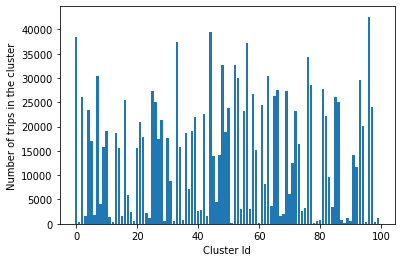

In [32]:
# Plot the trips frequency of each cluster
theData = train.groupby('pickup_cluster').count()[['id']]
theData = theData.to_numpy().flatten(order='C')
plt.bar(range(len(theData)),theData)

plt.xlabel('Cluster Id')
plt.ylabel('Number of trips in the cluster')
plt.show()

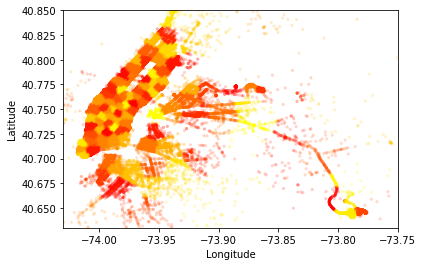

In [33]:
# Plot on the map's canvas the cluster that we have made
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [34]:
# Extract the months from data
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [35]:
# See the months spread in train and test data
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [36]:
# Now, check for the day in month.
# Again, check in train and test data
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [37]:
# We check again... all the way
# now with the hours
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [38]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

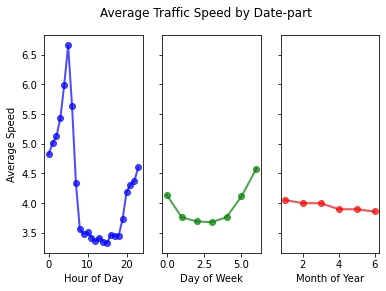

In [39]:
# Calculate the speed
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

# Plot and check whether speed changes in accordance to
# hour of day, day of week, month of year
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

# It seems that there exist some trend that changes
# in the function of hour, day, and month
# We could interpret and relate this speed graph
# with the frequency of traffic from previous graph
# higher average speed usually means less traffic

In [40]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,Month,DayofMonth,Hour,dayofweek,avg_speed_h,avg_speed_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,1.735,99.970,93,28,3,14,17,0,3.293,3.814
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,2.431,-117.154,47,72,6,12,0,6,2.723,3.666
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,8.204,-159.680,44,9,1,19,11,1,3.006,3.862
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,1.661,-172.738,38,83,4,6,19,2,3.463,3.873
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,1.199,179.474,42,45,3,26,13,5,2.732,2.757


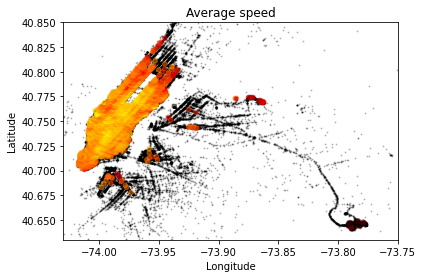

In [41]:
# Round the lat long value to 3 numbers decimal
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)

# Create a grid map with the accuracy of 3 numbers decimal
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
# Group all the data to their respective square grid...
# then calculate the average speed of each grid
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
# also calculate the total trip in each specific square grid
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)

# Filter the square grid, so that only grid with trip frequency
# over 100 may appear
coord_stats = coord_stats[coord_stats['id'] > 100]

fig, ax = plt.subplots(ncols=1, nrows=1)
# Sample the first 500.000 trips
# Black dots represent one trip
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.2)
# Speed is represented using hot_r color map
# The brighter the faster
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='hot_r', s=20, alpha=0.5, vmin=1, vmax=8)

ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [42]:
# One hot encode things...
# dummy variable is actually a 0 or 1 binary variable
# it is one hot encoding in this case
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [43]:
# check things, just to make sure
print(vendor_train.shape,vendor_test.shape)
print(passenger_count_train.shape,passenger_count_test.shape)
print(store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape)
print(cluster_pickup_train.shape,cluster_pickup_test.shape)
print(cluster_dropoff_train.shape,cluster_dropoff_test.shape)
print(month_train.shape,month_test.shape)
print(dom_train.shape,dom_test.shape)
print(hour_train.shape,hour_test.shape)
print(dow_train.shape,dow_test.shape)

(1437128, 2) (625134, 2)
(1437128, 7) (625134, 8)
(1437128, 2) (625134, 2)
(1437128, 100) (625134, 100)
(1437128, 100) (625134, 100)
(1437128, 6) (625134, 6)
(1437128, 31) (625134, 31)
(1437128, 24) (625134, 24)
(1437128, 7) (625134, 7)


In [44]:
# Drop the data with 9 passenger, because it is
# considered an outlier
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [45]:
# Drop the categorical variables, simply because
# we have one hot encode those things
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude',
                    'dropoff_latitude','pickup_datetime','pickup_date'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude',
                  'dropoff_latitude','pickup_datetime','pickup_date'], axis = 1)

In [46]:
train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m',
                    'pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [47]:
print(train.shape,test.shape)

(1437128, 6) (625134, 5)


In [48]:
# Concat the one hot encode columns
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [49]:
# Same for test set
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [50]:
print(Train_Master.shape,Test_master.shape)

(1446345, 285) (625134, 284)


In [51]:
# Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
# Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [52]:
print(Train_Master.shape,Test_master.shape)

(1446345, 285) (625134, 284)


In [65]:
# Split the train-test data
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [68]:
Train = Train.dropna(axis=0)
Test = Test.dropna(axis=0)

In [73]:
# Check whether data still have null
print(Train.isna().sum().any())
print(Test.isna().sum().any())

False
False


In [74]:
# Clear the data once more
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [75]:
X_test.head()

,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,vi_1,vi_2,pc_0,pc_1,pc_2,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
36606,4.125,5.497,25.436,30.000,33.000,1.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
92970,1.895,2.165,81.120,93.000,85.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
86171,2.654,2.846,-85.682,73.000,4.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
69031,14.916,18.643,17.063,58.000,89.000,1.000,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
73870,1.460,2.044,-143.172,73.000,63.000,1.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000


In [76]:
# Make the "bundle" data specialized for XGBoost
# It's more like .tfrecord in TF
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [77]:
# Train the model with many an array of
# possible configurations
md = [6]
lr = [0.1,0.3]
mcw = [20,25,30]
for m in md:
   for l in lr:
       for mc in mcw:
           t0 = datetime.now()
           xgb_pars = {'min_child_weight': mc, 'eta': l, 'colsample_bytree': 0.9, 
                       'max_depth': m,
           'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
           'eval_metric': 'rmse', 'objective': 'reg:linear'}
           model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10,
                 maximize=False, verbose_eval=1)

[0]	train-rmse:5.40195	valid-rmse:5.40237
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:4.86593	valid-rmse:4.86666
[2]	train-rmse:4.38389	valid-rmse:4.38493
[3]	train-rmse:3.95058	valid-rmse:3.95197
[4]	train-rmse:3.56108	valid-rmse:3.56281
[5]	train-rmse:3.21114	valid-rmse:3.2131
[6]	train-rmse:2.89676	valid-rmse:2.89904
[7]	train-rmse:2.61443	valid-rmse:2.617
[8]	train-rmse:2.36109	valid-rmse:2.36381
[9]	train-rmse:2.13387	valid-rmse:2.13687
[10]	train-rmse:1.93026	valid-rmse:1.93373
[11]	train-rmse:1.74793	valid-rmse:1.7518
[12]	train-rmse:1.58472	valid-rmse:1.5889
[13]	train-rmse:1.43901	valid-rmse:1.44359
[14]	train-rmse:1.30919	valid-rmse:1.31414
[15]	train-rmse:1.1936	valid-rmse:1.19892
[16]	train-rmse:1.09077	valid-rmse:1.09662
[17]	train-rmse:0.999713	valid-rmse:1.00599
[18]	train-rmse:0.919279	valid-rmse:0.926096
[19]	train-rmse:0.848569	valid-rmse:0.855759
[20]	t

In [78]:
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.42005


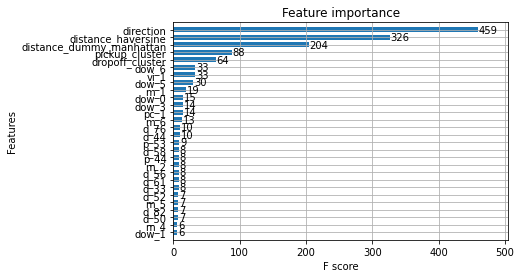

In [79]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

In [80]:
# Predict the test set using the fitted model
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [81]:
# This is the resulting prediction for the test data
predDF = pd.DataFrame(pred)
predDF

,0
0,1138.505
1,927.712
2,518.416
3,1196.457
4,372.608
...,...
625129,291.324
625130,1125.758
625131,1411.976
625132,2080.299


In [ ]:
# Make sure to uncomment the unzip once you're done